<a href="https://colab.research.google.com/github/sebastian-jarosz/pandas_laboratory/blob/main/Uczenie_Maszynowe_Lab_Cw3_Jarosz_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

4431872/4422102 [==============================] - 0s 0us/step
[0.0, 0.1866769790649414, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8133230209350586, 0.0, 0.0]
[0.7723109722137451, 0.0, 0.22768902778625488, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.387019636453715e-10, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9996637105941772, 0.0003362894058227539]
[0.0, 0.0, 0.0, 0.0, 0.9999878406524658, 0.0, 0.0, 0.0, 1.2159347534179688e-05, 0.0]
[0.0, 0.0, 0.17610789835453033, 0.0, 0.8238921165466309, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.9946864247322083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005313596222549677, 0.0, 0.0]
[0.14001674950122833, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8599832653999329, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Epoch 1/10
907/907 [==============================] - 62s 65ms/step - loss: 1.1874 - accuracy: 0.6273 - val_loss: 0.7064 - val_accuracy: 0.7510
Epoch 2/10
907/907 [==============================] - 38s 42ms/step - loss: 0.9506 - accuracy:

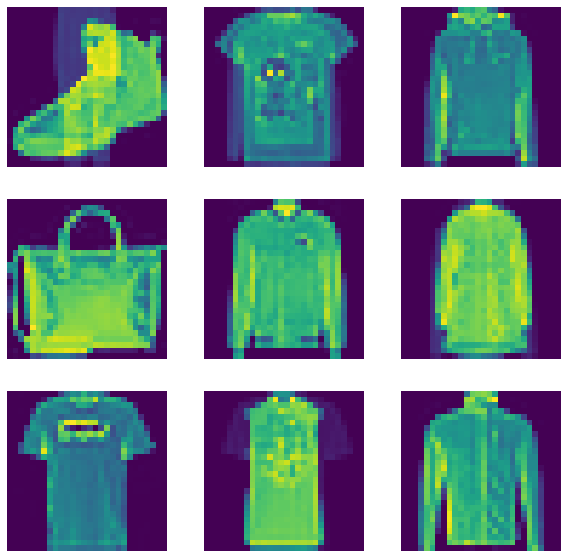

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# Prepare dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.one_hot(y_train, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.one_hot(y_test, 10)

# Hyperparameters definition
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 10

# Data into TensorFlow Dataset objects
# Put aside a few samples to create our validation set
val_samples = 2000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

# Mixupt technique function definition
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

# New augumented dataset visualisation
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO
)

# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

# Model building
def get_training_model():
    model = tf.keras.Sequential(
        [
            layers.Conv2D(16, (5, 5), activation="relu", input_shape=(28, 28, 1)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.2),
            layers.GlobalAvgPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

initial_model = get_training_model()
initial_model.save_weights("initial_weights.h5")

# Model training with the mixed up dataset
model = get_training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_mu, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

# Model training without the mixed up dataset
model = get_training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# Notice that we are NOT using the mixed up dataset here
model.fit(train_ds_one, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))


